<a href="https://colab.research.google.com/github/NITHISHM2410/Alzheimers-Detection-and-Classification/blob/main/Notebooks/few_shot_similarity_nn/FewShotLearning_Similarity_Model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import re
import shutil
import random
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 5.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Parsing Records**

In [3]:
def parser(example):
    feature = {
        'wave1':tf.io.FixedLenFeature([],tf.string),
        'wave2':tf.io.FixedLenFeature([],tf.string),
        'state':tf.io.FixedLenFeature([],tf.string),
        'diff':tf.io.FixedLenFeature([],tf.string),
    }
    feature = tf.io.parse_single_example(example,feature)

    wave1 = tf.io.parse_tensor(feature['wave1'],out_type = tf.float32)
    wave1 = tf.reshape(wave1,(1024,19))

    wave2 = tf.io.parse_tensor(feature['wave2'],out_type = tf.float32)
    wave2 = tf.reshape(wave2,(1024,19))

    state = tf.io.parse_tensor(feature['state'],out_type = tf.float32)
    state = tf.reshape(state,(2,))

    diff = tf.io.parse_tensor(feature['diff'],out_type = tf.float32)
    diff = tf.reshape(diff,(1,))

    
    return {'wave1':wave1,'wave2':wave2,'state':state},{'difference':diff}


In [4]:
batch_size = 32

In [5]:
def get_ds(ds):
    ds = tf.data.TFRecordDataset(ds,compression_type = "GZIP")
    ds = ds.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 300)
    ds = ds.batch(33,drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
train_ds = get_ds("/content/drive/MyDrive/fewshotlatest/train_rec")
test_ds = get_ds("/content/drive/MyDrive/fewshotlatest/test_rec")
val_ds = get_ds("/content/drive/MyDrive/fewshotlatest/val_rec")

In [7]:
train_ds

<_PrefetchDataset element_spec=({'wave1': TensorSpec(shape=(33, 1024, 19), dtype=tf.float32, name=None), 'wave2': TensorSpec(shape=(33, 1024, 19), dtype=tf.float32, name=None), 'state': TensorSpec(shape=(33, 2), dtype=tf.float32, name=None)}, {'difference': TensorSpec(shape=(33, 1), dtype=tf.float32, name=None)})>

**Squared Difference Layer**

In [8]:
class SQD(tf.keras.layers.Layer):
    def __init__(self):
        super(SQD, self).__init__()
    def call(self, inputs):
        x, y = inputs
        diff = tf.subtract(x, y)
        return tf.square(diff)
    

**LSTM and Siamese Layer**

In [9]:
def wave_downsample():
    input = tf.keras.Input(batch_size = batch_size,shape = (1024,19))
    output = tf.keras.layers.LSTM(10,return_sequences = True)(input)
    output = tf.keras.layers.Dense(2)(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Activation('relu')(output)
    output = tf.keras.layers.Dropout(0.3)(output)
    output = tf.keras.layers.Dense(20)(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    model = tf.keras.Model(inputs = [input],outputs = [output])
    return model
     
def get_model():
    wave1 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave1')
    wave2 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave2')
    state = tf.keras.Input(batch_size = batch_size,shape = (2,),name = 'state')
    
    output1 = tf.keras.layers.BatchNormalization()(wave1)
    output2 = tf.keras.layers.BatchNormalization()(wave2)

    down_sampler = wave_downsample()
    output1 = down_sampler(output1)
    output2 = down_sampler(output2)

    output1 = tf.keras.layers.Activation('tanh')(output1)
    output1 = tf.keras.layers.Dropout(0.3)(output1)

    output2 = tf.keras.layers.Activation('tanh')(output2)
    output2 = tf.keras.layers.Dropout(0.3)(output2)

    output = SQD()([output1,output2])
    output = tf.keras.layers.concatenate([output,state])
    output = tf.keras.layers.Dense(10)(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'difference' )(output)
    
    model = tf.keras.Model(inputs = [wave1,wave2,state],outputs = [output],name = 'FewShot')
    return model

In [10]:
model = get_model()
model.summary()

Model: "FewShot"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wave1 (InputLayer)             [(32, 1024, 19)]     0           []                               
                                                                                                  
 wave2 (InputLayer)             [(32, 1024, 19)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (32, 1024, 19)      76          ['wave1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 batch_normalization_1 (BatchNo  (32, 1024, 19)      76          ['wave2[0][0]']            

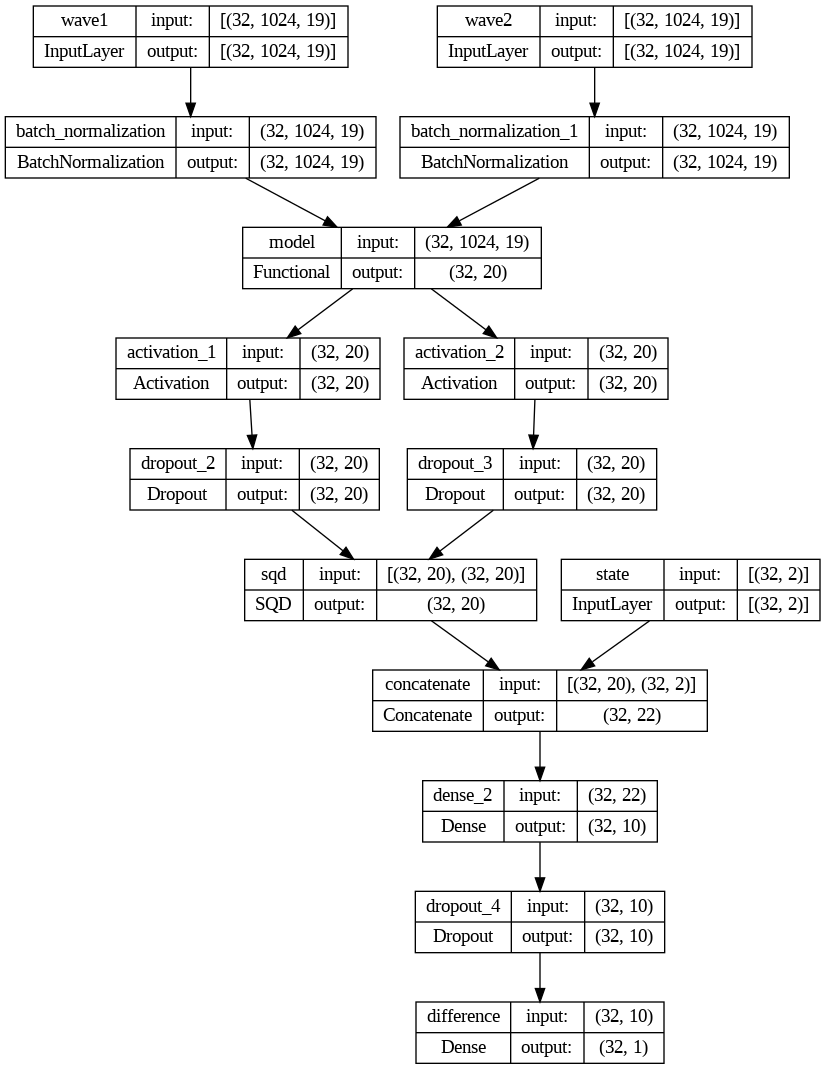

In [11]:
tf.keras.utils.plot_model(model,show_shapes = True,show_layer_names = True)

In [12]:
cbs = tf.keras.callbacks.ModelCheckpoint("weights_model/best_one",monitor = 'val_loss',save_best_only = True,save_weights_only = True)

In [13]:
model = get_model()

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = 'binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.8),
                         tfa.metrics.F1Score(num_classes=1,threshold = 0.8)])

In [20]:
model.fit(train_ds,epochs = 3,validation_data = val_ds,callbacks = [cbs])

Epoch 1/3
8/8 [==============================] - 10s 228ms/step - loss: 0.2083 - binary_accuracy: 0.9318 - f1_score: 0.9328 - val_loss: 0.0073 - val_binary_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 2/3
8/8 [==============================] - 1s 76ms/step - loss: 0.1329 - binary_accuracy: 0.9470 - f1_score: 0.9466 - val_loss: 0.0958 - val_binary_accuracy: 0.9697 - val_f1_score: 0.9730
Epoch 3/3
8/8 [==============================] - 1s 84ms/step - loss: 0.2116 - binary_accuracy: 0.8977 - f1_score: 0.8907 - val_loss: 0.0069 - val_binary_accuracy: 1.0000 - val_f1_score: 1.0000


Archiving and Reloading and testing the model score

In [ ]:
model.save_weights("/content/my_weights/best_till_now")

In [ ]:
shutil.make_archive("/content/best_weights_till_now","zip","/content/my_weights")

'/content/best_weights_till_now.zip'

In [ ]:
shutil.move("/content/best_weights_till_now.zip","/content/drive/MyDrive/weights")

In [21]:
!unzip "/content/drive/MyDrive/weights/best_weights_till_now.zip" -d "/content/weights/"

Archive:  /content/drive/MyDrive/weights/best_weights_till_now.zip
replace /content/weights/best_till_now.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/weights/best_till_now.index  
  inflating: /content/weights/best_till_now.data-00000-of-00001  
  inflating: /content/weights/checkpoint  


In [22]:
model.load_weights("/content/weights/best_till_now")
model.evaluate(test_ds)

2/2 [==============================] - 1s 83ms/step - loss: 0.0046 - binary_accuracy: 1.0000 - f1_score: 1.0000


[0.004644440952688456, 1.0, array([1.], dtype=float32)]

# PLOTTING TRUE VS PREDICTED VALUES

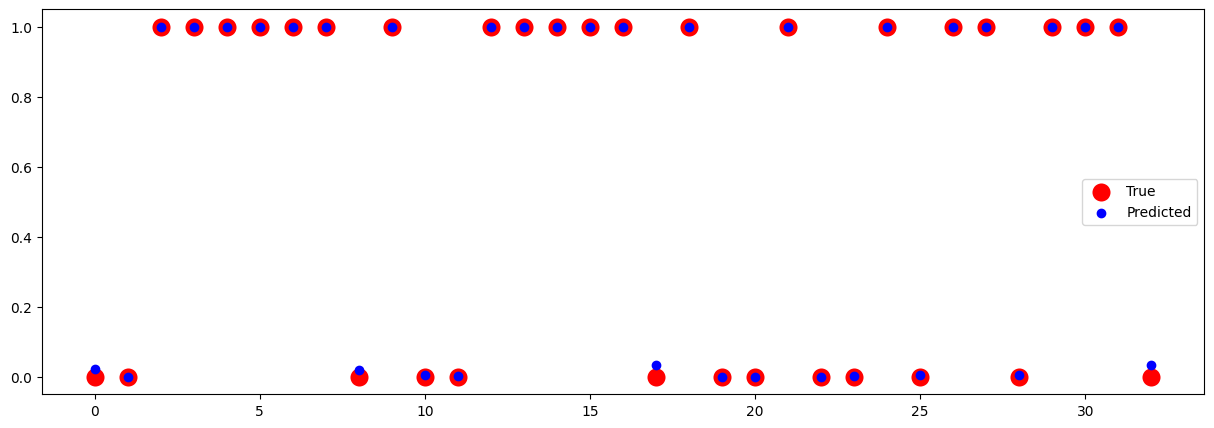

In [25]:
plt.figure(figsize = (15,5))
for _,(x,y) in enumerate(test_ds):
    y_true = np.squeeze(y['difference'])
    y_pred = np.squeeze(model(x))
    plt.scatter([i for i in range(0,33)],y_true,color = 'red',linewidths = 7,label = 'True')
    plt.scatter([i for i in range(0,33)],y_pred,color = 'blue',label = 'Predicted')
    plt.legend()
    plt.show()
    break